# Gas usage by component and opcode - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_sample", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from data.gas_cost import compute_component_gas_costs_per_tx

## 2. Load data

Now, let's load the data. We will start by loading the opcodes data for the sampled blocks.

In [6]:
block_start = 22000000
block_end = 22300000
# Load parquet files with duckdb
query = f"""
SELECT *
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Clean up repeated opcodes
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("DUP"), "DUP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("SWAP"), "SWAP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    (agg_trace_df["op"].str.startswith("PUSH")) & (agg_trace_df["op"] != "PUSH0"),
    "PUSH",
    agg_trace_df["op"],
)
# Compute total gas cost for opcode
agg_trace_df["op_total_gas_cost"] = (
    agg_trace_df["op_gas_cost"] * agg_trace_df["op_gas_pair_count"]
)
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90312290 entries, 0 to 90312289
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tx_hash            object 
 1   op                 object 
 2   op_gas_cost        float64
 3   post_memory_size   float64
 4   memory_expansion   float64
 5   memory_size        float64
 6   cum_refund         int64  
 7   call_address       object 
 8   op_gas_pair_count  int64  
 9   block_height       int64  
 10  op_total_gas_cost  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 7.4+ GB


In [7]:
agg_trace_df["block_height"].agg(["min", "max"])

min    22000017
max    22299951
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [8]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_sample.parquet")
)
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994992 entries, 0 to 994991
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            994992 non-null  int64 
 1   tx_hash                 994992 non-null  object
 2   tx_gas_cost             994992 non-null  int64 
 3   tx_gas_limit            994992 non-null  int64 
 4   tx_input_zero_bytes     994992 non-null  int64 
 5   tx_input_nonzero_bytes  994992 non-null  int64 
 6   tx_input_data_cost      994992 non-null  int64 
 7   is_contract_creation    994992 non-null  bool  
 8   is_success              994992 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 55.0+ MB


## 3. Process data

In [9]:
# Compute gas costs by component
comp_df = compute_component_gas_costs_per_tx(agg_trace_df, tx_gas_info_df)
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994992 entries, 0 to 994991
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           994992 non-null  int64  
 1   tx_hash                994992 non-null  object 
 2   total_gas_cost         994992 non-null  int64  
 3   input_data_cost        994992 non-null  int64  
 4   intrinsic_base_cost    994992 non-null  float64
 5   op_gas_cost            994992 non-null  float64
 6   gas_refund             994992 non-null  float64
 7   intrinsic_access_cost  994992 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 60.7+ MB


In [10]:
strange_access_txs = comp_df[~comp_df["intrinsic_access_cost"].between(0, 4000000)][
    "tx_hash"
].values.tolist()
fail_txs = tx_gas_info_df[~tx_gas_info_df["is_success"]]["tx_hash"].values.tolist()
ignore_txs = fail_txs + strange_access_txs

In [11]:
filtered_comp_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)]

## 4. Gas usage by component

### Component total contribution

In [12]:
melt_comp_df = filtered_comp_df.drop(columns=["total_gas_cost"])
melt_comp_df.columns = [
    "block_height",
    "tx_hash",
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
melt_comp_df = melt_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost"
)

compt_stats = melt_comp_df.groupby("component")["cost"].agg(
    ["sum", "mean", "std", "median"]
)
compt_stats

sum          mean            std   median
component                                                           
Input data        3.245058e+09   3357.306142   46656.928468    608.0
Intrinsic access  3.783013e+09   3913.869484   48226.271473      0.0
Intrinsic base    2.033123e+10  21034.497386    1050.108285  21000.0
Opcode            8.408763e+10  86996.258205  586315.523423  24501.0
Refund            6.128263e+09   6340.242260   24780.590973      0.0

In [13]:
compt_stats["sum"] / filtered_comp_df["total_gas_cost"].sum()

component
Input data          0.030812
Intrinsic access    0.035920
Intrinsic base      0.193045
Opcode              0.798411
Refund              0.058188
Name: sum, dtype: float64

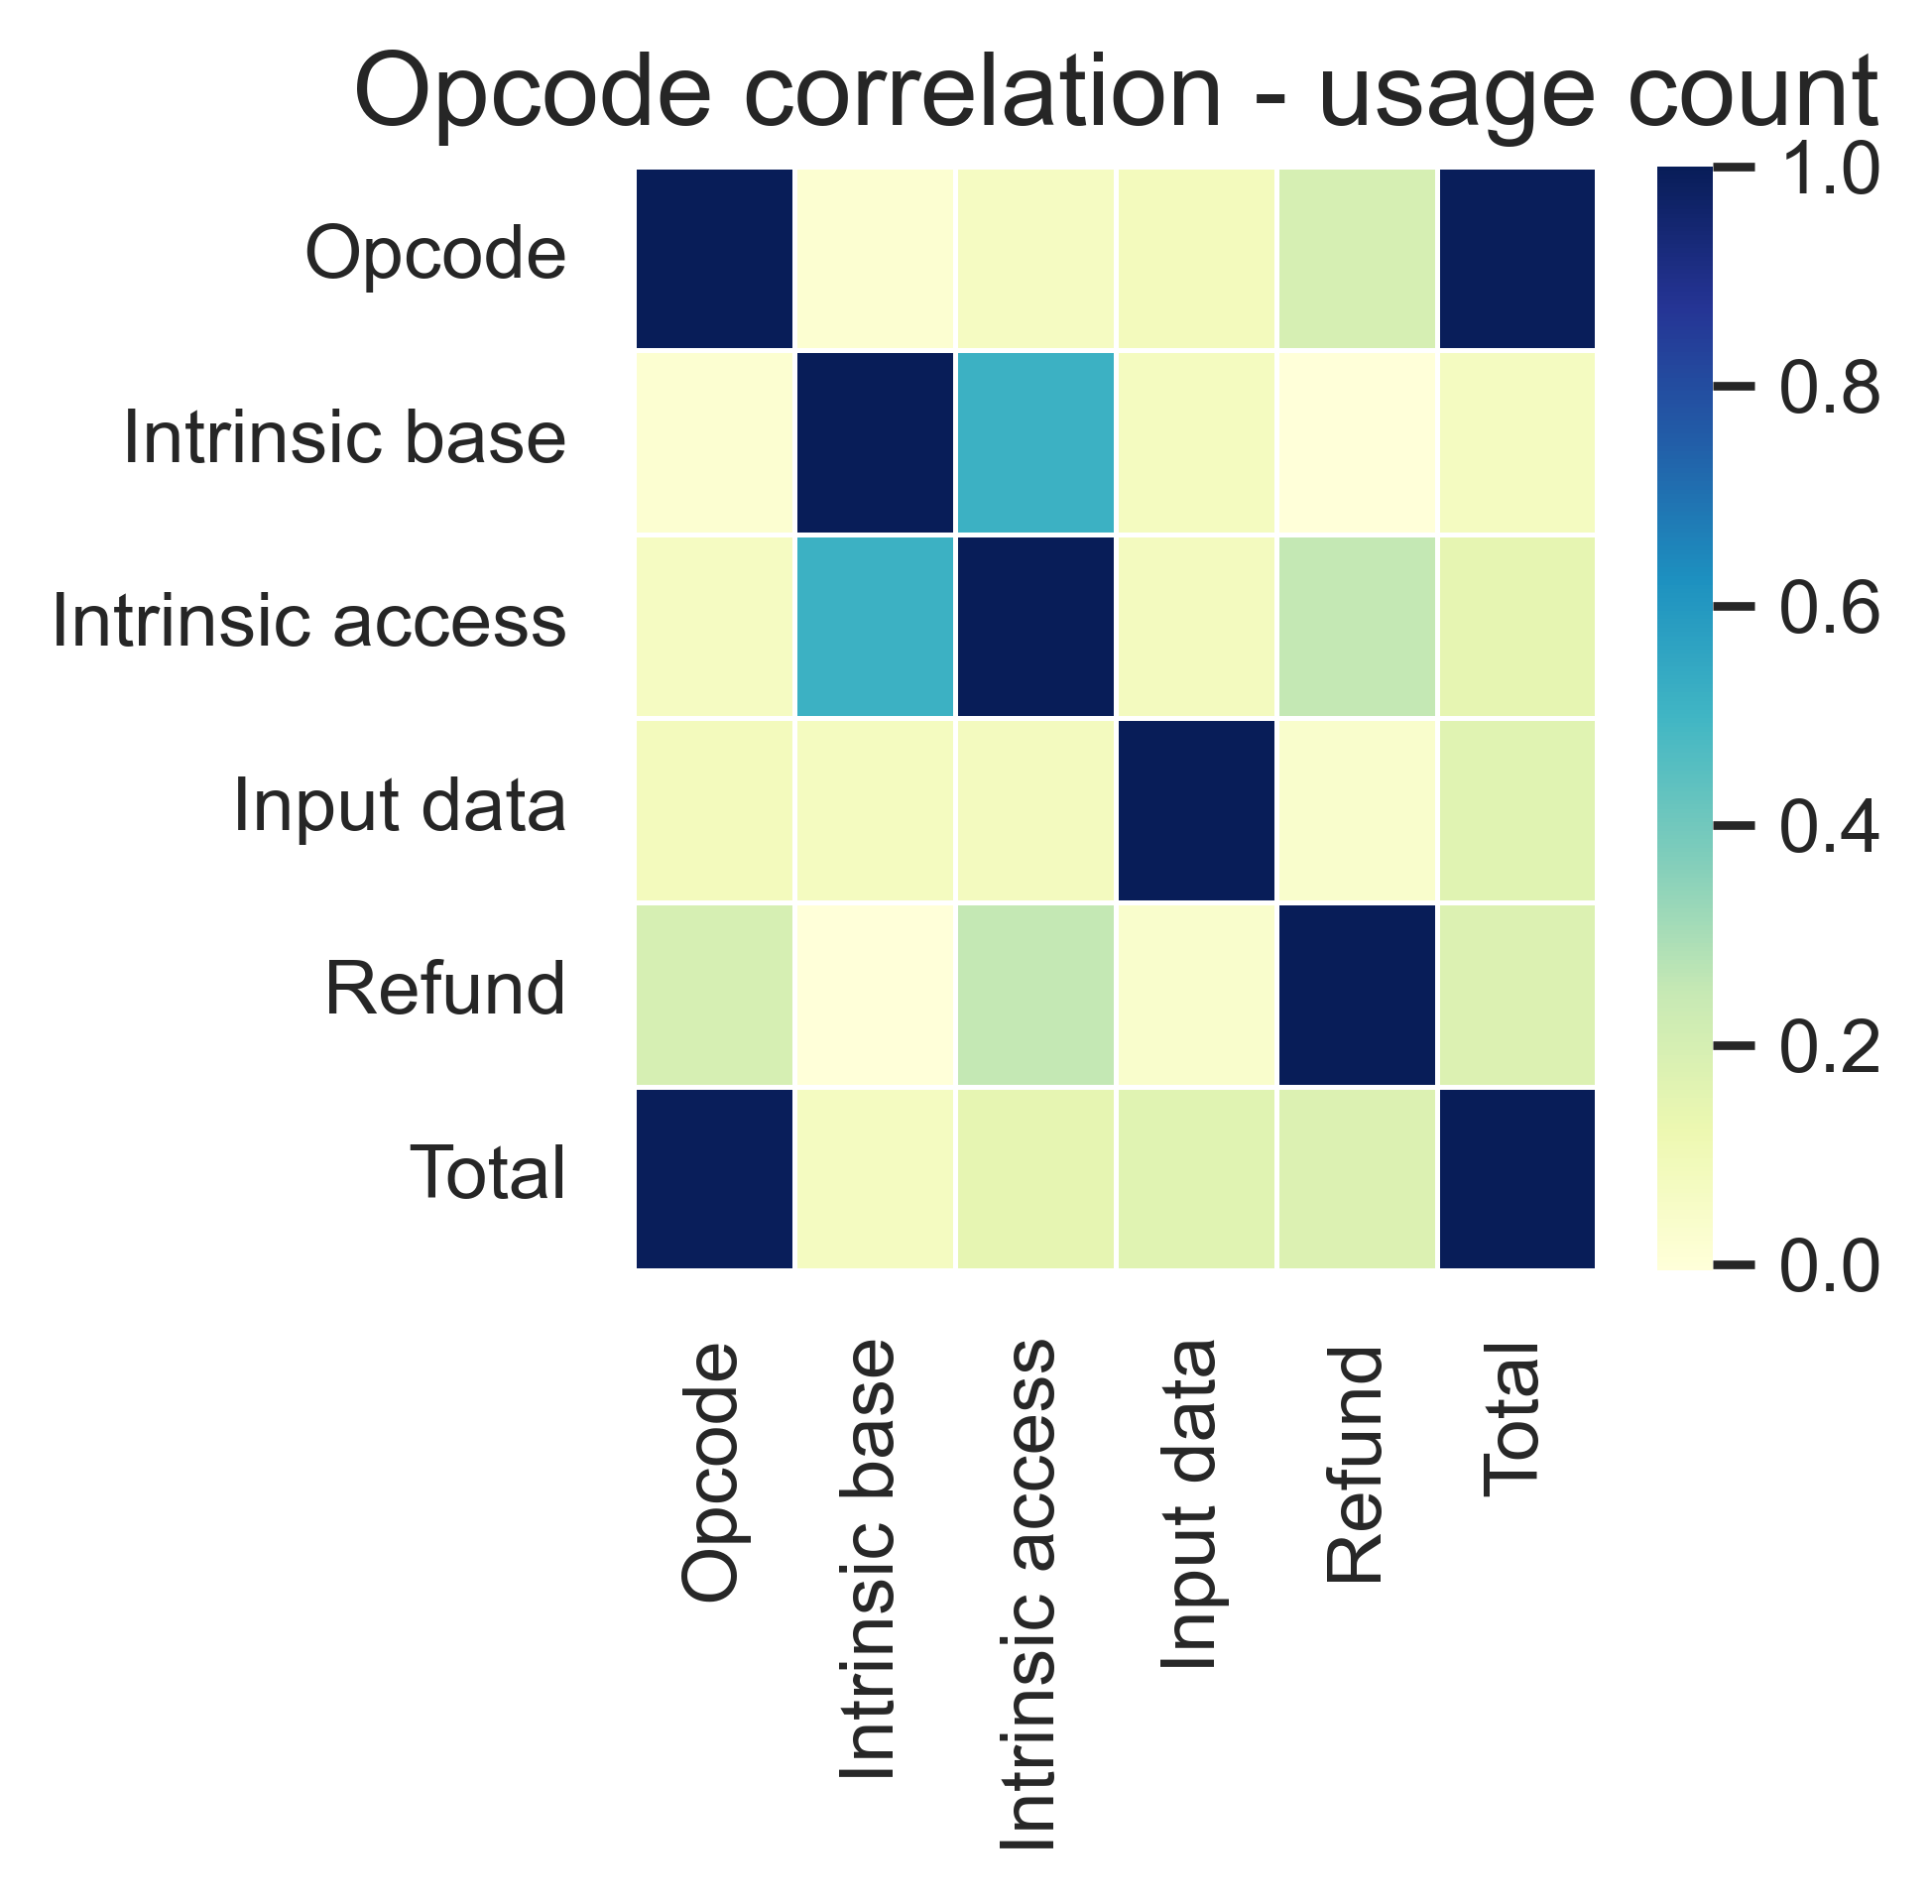

In [15]:
temp_df = filtered_comp_df.drop(columns=["block_height"]).set_index("tx_hash")
temp_df.columns = [
    "Total",
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
temp_df = temp_df[
    ["Opcode", "Intrinsic base", "Intrinsic access", "Input data", "Refund", "Total"]
]
corr_mat = temp_df.corr()
plt.figure(figsize=(4, 4))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
plt.tight_layout()
plt.show()

### Component percentage over transaction cost

In [16]:
melt_perc_comp_df = filtered_comp_df.drop(columns=["total_gas_cost"])
cols = [
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
melt_perc_comp_df.columns = ["block_height", "tx_hash"] + cols
melt_perc_comp_df[cols] = melt_perc_comp_df[cols].div(
    filtered_comp_df["total_gas_cost"], axis=0
)
melt_perc_comp_df = melt_perc_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost_perc"
)

melt_perc_comp_df.groupby("component")["cost_perc"].agg(["mean", "std", "median"])

mean       std    median
component                                     
Input data        0.015245  0.031314  0.010206
Intrinsic access  0.011280  0.058922  0.000000
Intrinsic base    0.571041  0.362700  0.472409
Opcode            0.440713  0.378366  0.531371
Refund            0.038280  0.070581  0.000000

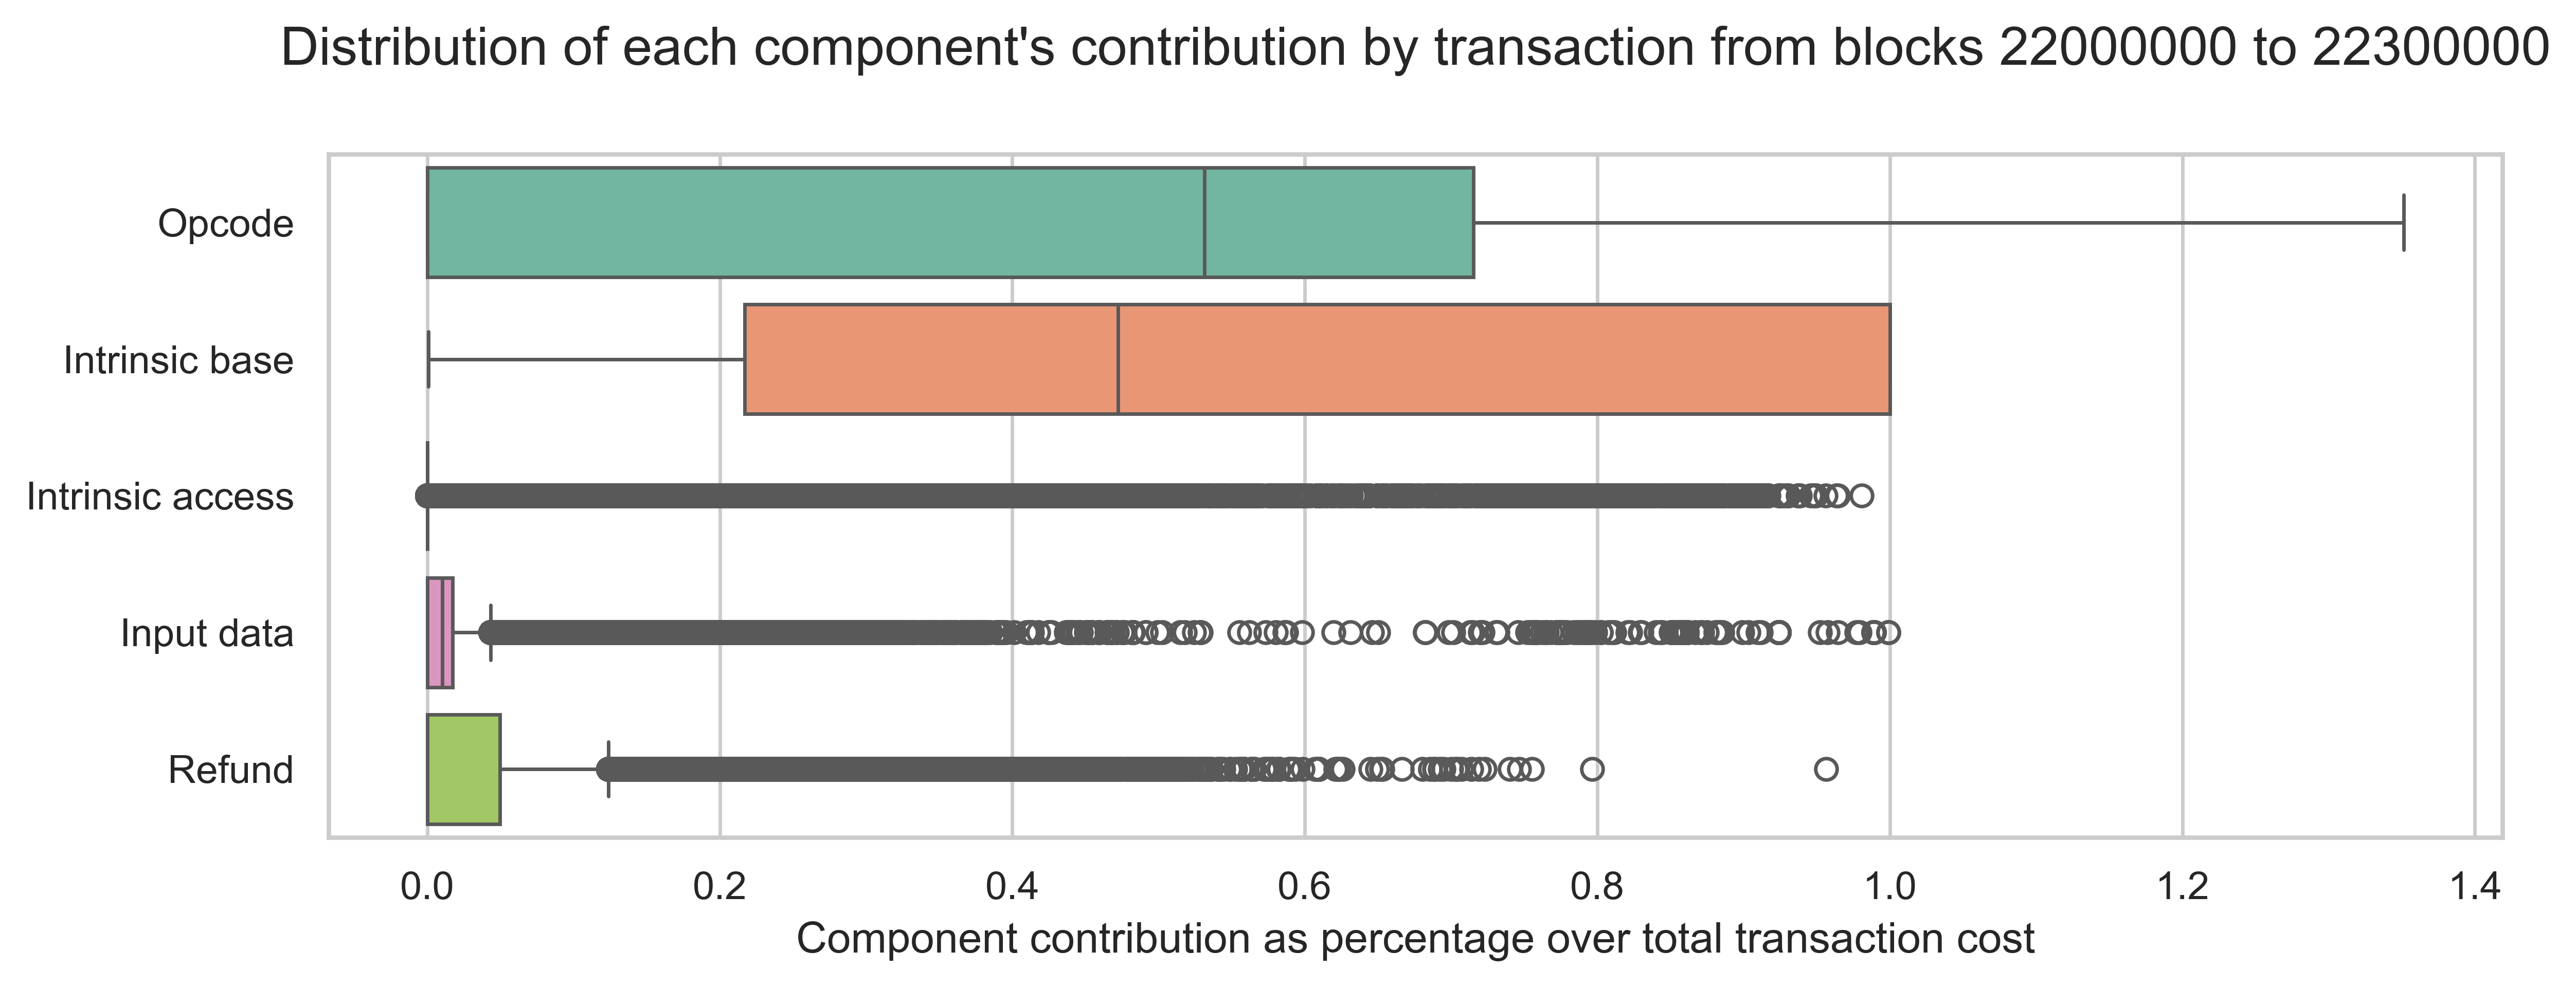

In [17]:
temp_df = melt_perc_comp_df[melt_perc_comp_df["component"] != "Refund"].sort_values(
    "component", ascending=False
)
temp_df = pd.concat(
    [temp_df, melt_perc_comp_df[melt_perc_comp_df["component"] == "Refund"]]
)
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="component",
    x="cost_perc",
    data=temp_df,
    hue="component",
    legend=False,
)
plt.title(
    f"Distribution of each component's contribution by transaction from blocks {block_start} to {block_end}",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Component contribution as percentage over total transaction cost")
plt.tight_layout()
plt.show()

#### Aditional examples and stats

In [18]:
total_txs = len(filtered_comp_df)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["op_gas_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No opcode costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No intrinsic access costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["gas_refund"] > 0.0]) / total_txs, 5
    ),
    "-- With refunds",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["input_data_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High input data costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High intrinsic access costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] != 0.0]),
        5,
    ),
    "-- High intrinsic access costs over txs with this cost component",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["gas_refund"] > 0.0])
        / len(filtered_comp_df[filtered_comp_df["op_gas_cost"] > 0.0]),
        5,
    ),
    "-- Txs with refunds over txs with opcode costs",
)

0.37015 -- No opcode costs
0.91822 -- No intrinsic access costs
0.31223 -- With refunds
0.0004 -- High input data costs
0.0003 -- High intrinsic access costs
0.00362 -- High intrinsic access costs over txs with this cost component
0.49571 -- Txs with refunds over txs with opcode costs


## 5. Gas usage by opcode

In [21]:
filtered_usage_df = agg_trace_df[
    (~agg_trace_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (~agg_trace_df["tx_hash"].isin(ignore_txs))
]
filtered_usage_df["op"] = np.where(
    filtered_usage_df["op"].str.startswith("LOG"), "LOG", filtered_usage_df["op"]
)

In [22]:
filtered_usage_df["op"].nunique()

84

### Opcode usage counts

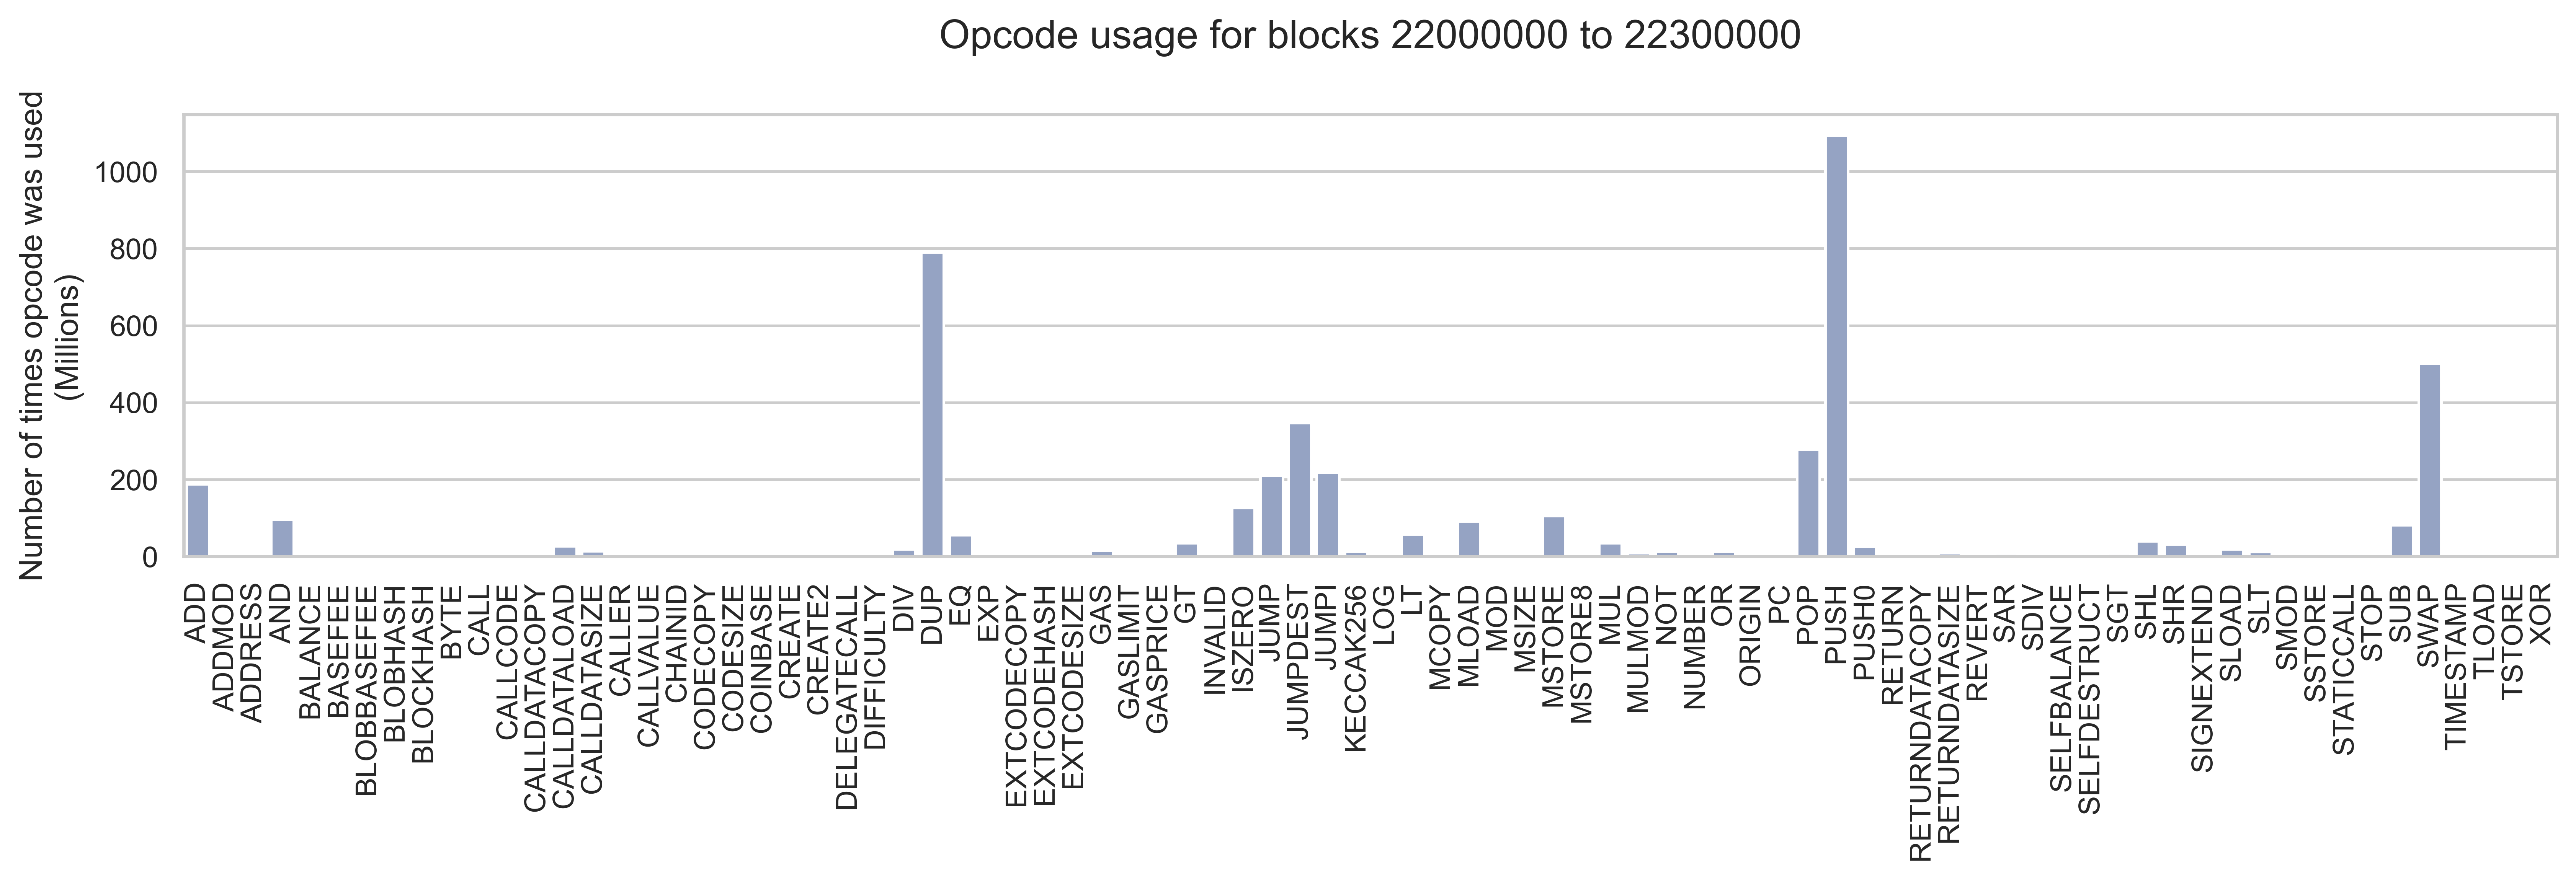

In [23]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

In [24]:
temp_df = (
    filtered_usage_df.groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
    .sort_values("op_gas_pair_count", ascending=False)
    .head(15)
)
temp_df["op_gas_pair_count_perc"] = temp_df["op_gas_pair_count"]/temp_df["op_gas_pair_count"].sum()
temp_df

op  op_gas_pair_count  op_gas_pair_count_perc
58      PUSH         1094128999                0.258078
26       DUP          790443032                0.186446
79      SWAP          500666717                0.118095
39  JUMPDEST          347175000                0.081890
57       POP          278568091                0.065707
40     JUMPI          217806616                0.051375
38      JUMP          209925559                0.049516
0        ADD          187427582                0.044209
37    ISZERO          126393306                0.029813
48    MSTORE          105656973                0.024922
3        AND           95717940                0.022577
45     MLOAD           91442306                0.021569
78       SUB           81479617                0.019219
43        LT           56981940                0.013441
27        EQ           55719789                0.013143

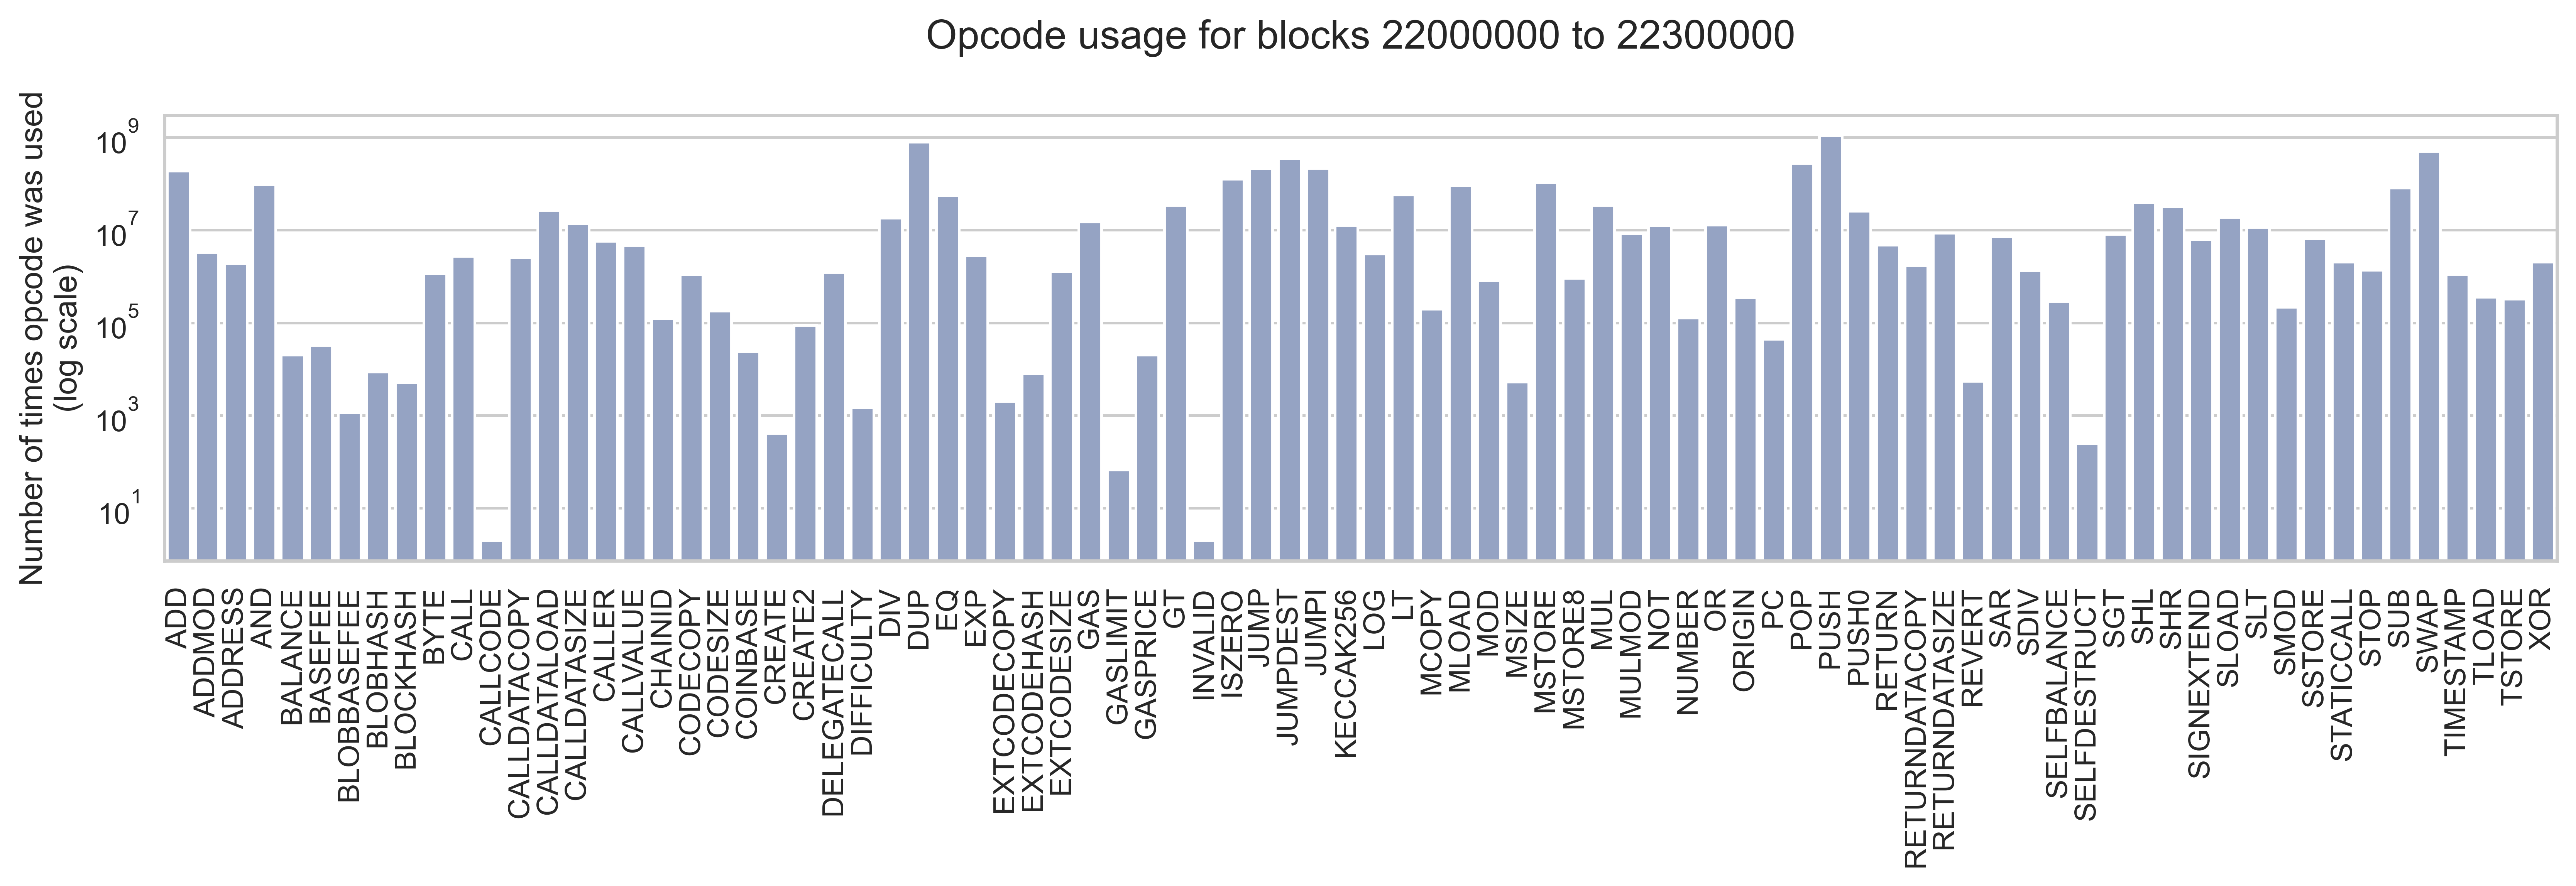

In [25]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

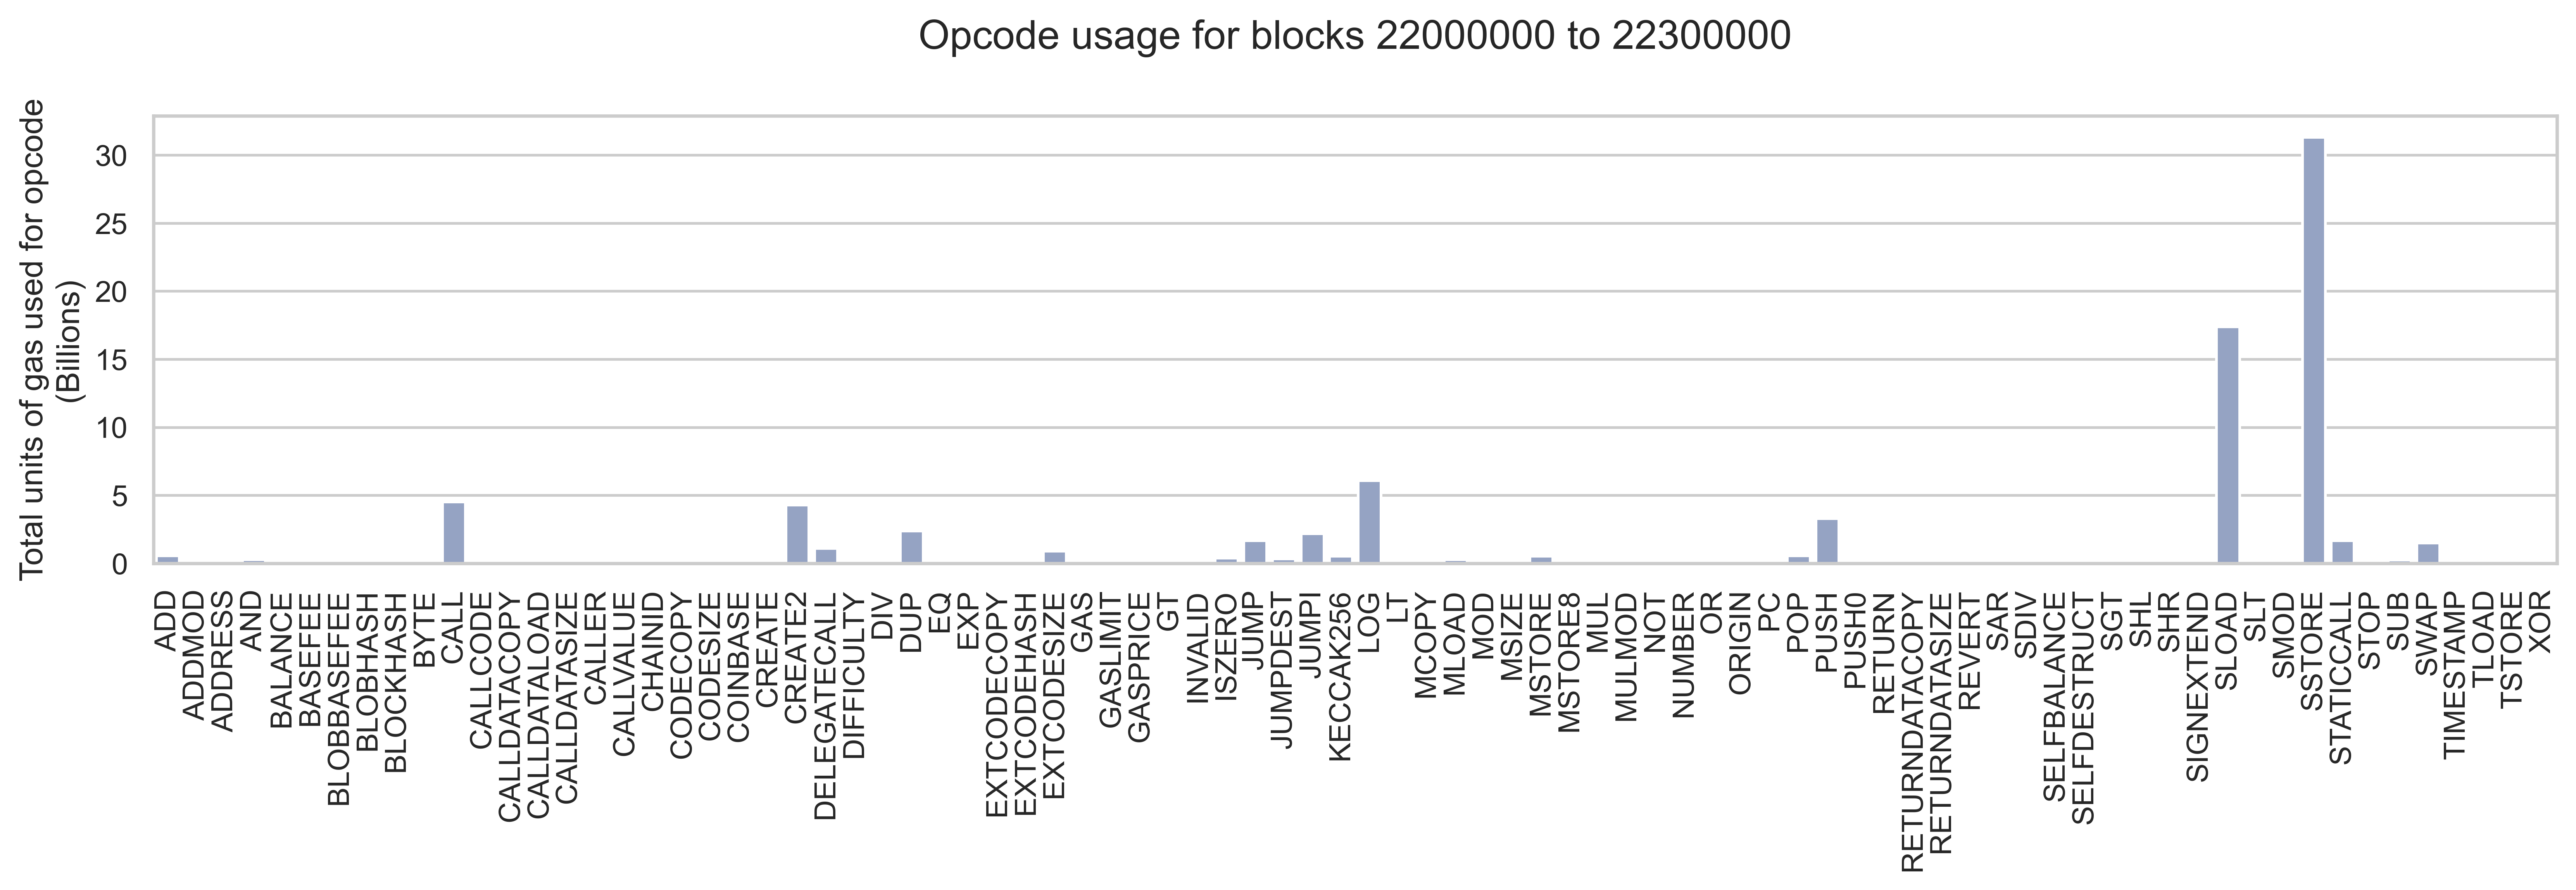

In [26]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

In [31]:
temp_df = (
    filtered_usage_df.groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
    .sort_values("op_total_gas_cost", ascending=False)
    .head(15)
)
temp_df["op_total_gas_cost_perc"] = (
    temp_df["op_total_gas_cost"] / temp_df["op_total_gas_cost"].sum()
)
print(
    temp_df[temp_df["op"].isin(["DELEGATECALL", "STATICCALL", "CALL", "CALLCODE"])][
        "op_total_gas_cost"
    ].sum()
    / temp_df["op_total_gas_cost"].sum()
, "-- call-type cost")
print(
    temp_df[temp_df["op"].isin(["CREATE", "CREATE2"])][
        "op_total_gas_cost"
    ].sum()
    / temp_df["op_total_gas_cost"].sum()
, "-- create-type cost")
temp_df

0.09199428662944381 -- call-type cost
0.05415088160821072 -- create-type cost


op  op_total_gas_cost  op_total_gas_cost_perc
75        SSTORE       3.131824e+10                0.394110
72         SLOAD       1.739676e+10                0.218922
42           LOG       6.085861e+09                0.076585
10          CALL       4.526093e+09                0.056957
22       CREATE2       4.303135e+09                0.054151
58          PUSH       3.282387e+09                0.041306
26           DUP       2.371329e+09                0.029841
40         JUMPI       2.178066e+09                0.027409
76    STATICCALL       1.685801e+09                0.021214
38          JUMP       1.679404e+09                0.021134
79          SWAP       1.502000e+09                0.018901
23  DELEGATECALL       1.098493e+09                0.013823
31   EXTCODESIZE       9.186579e+08                0.011560
0            ADD       5.622827e+08                0.007076
57           POP       5.571362e+08                0.007011

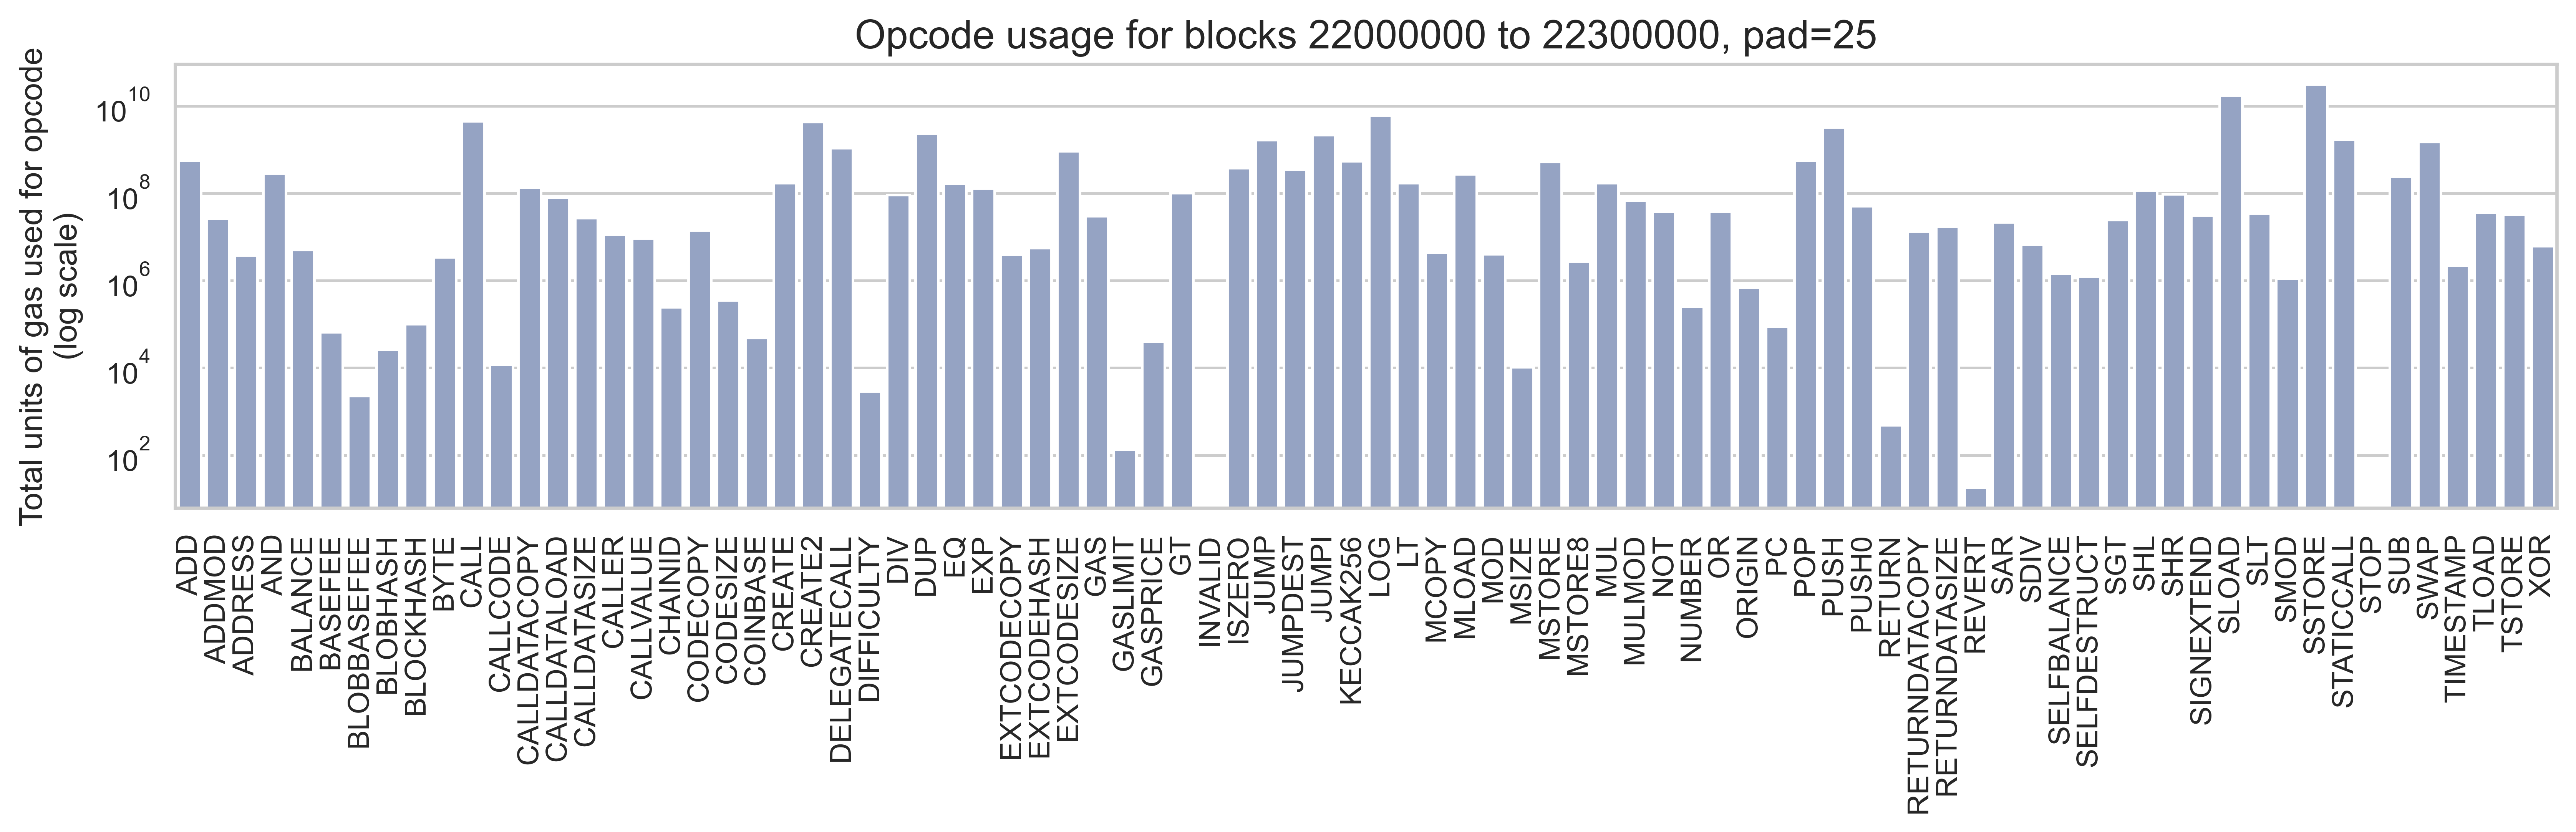

In [28]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title(f"Opcode usage for blocks {block_start} to {block_end}, pad=25")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

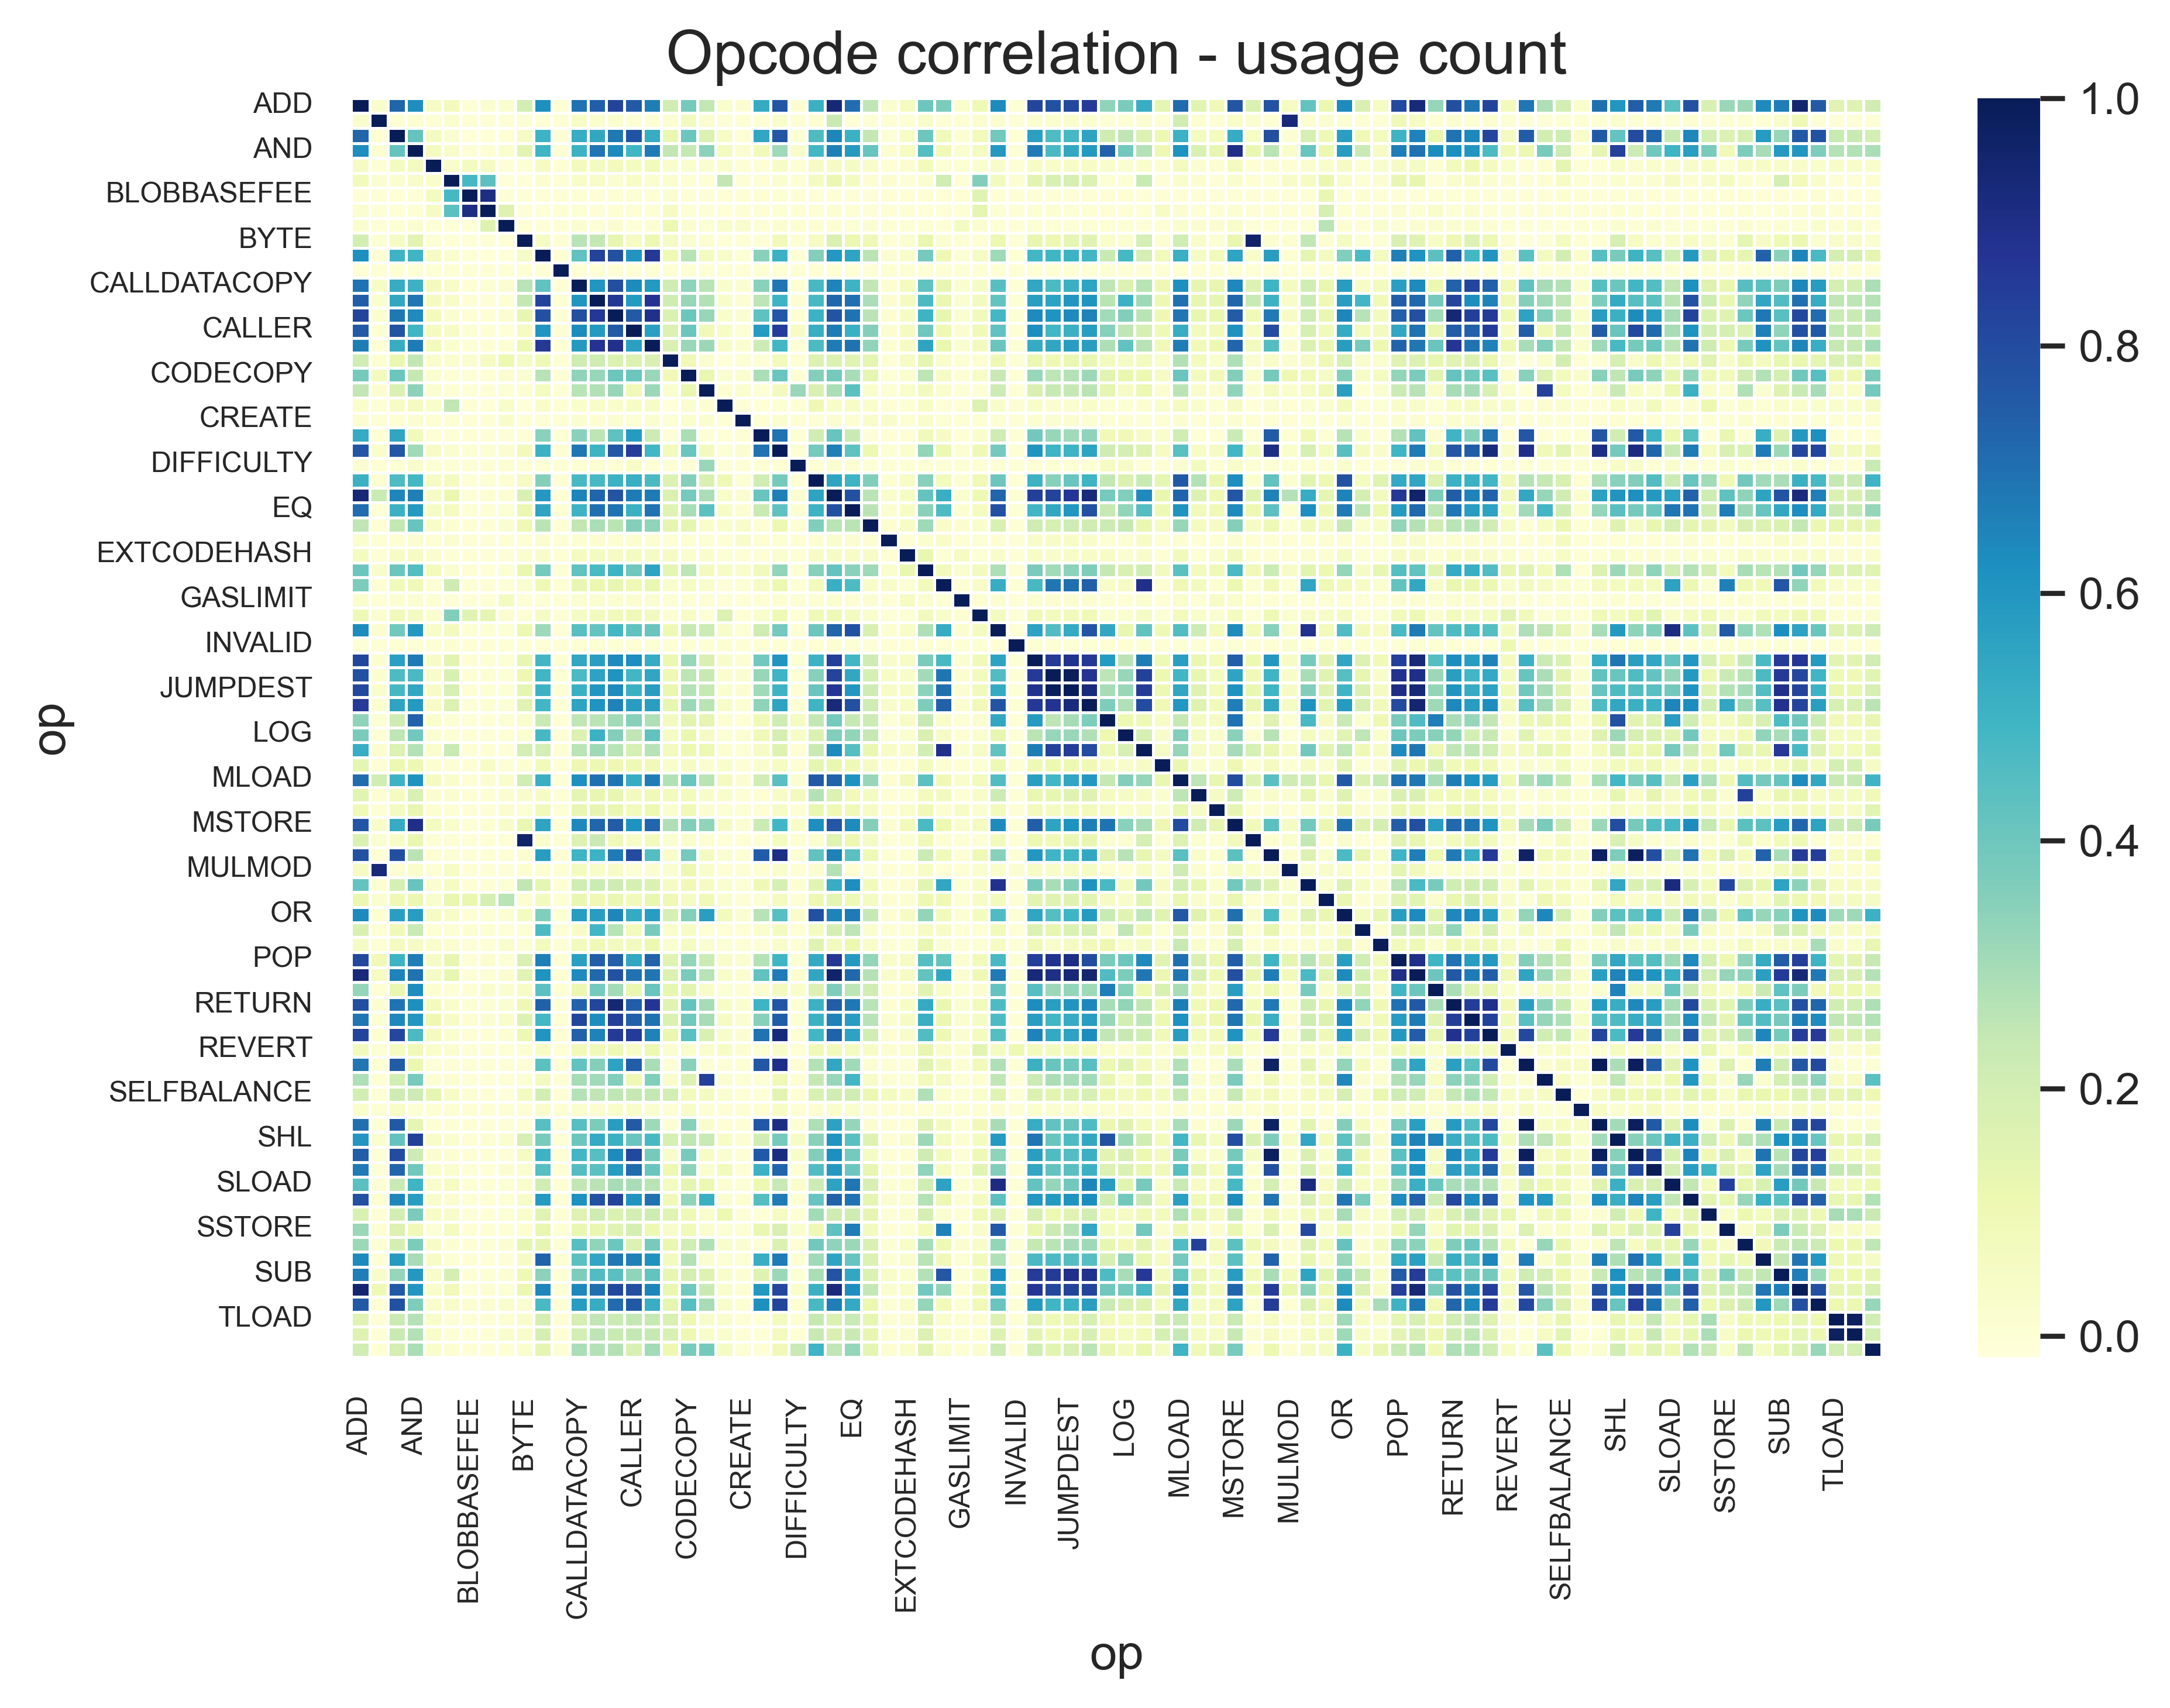

In [29]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

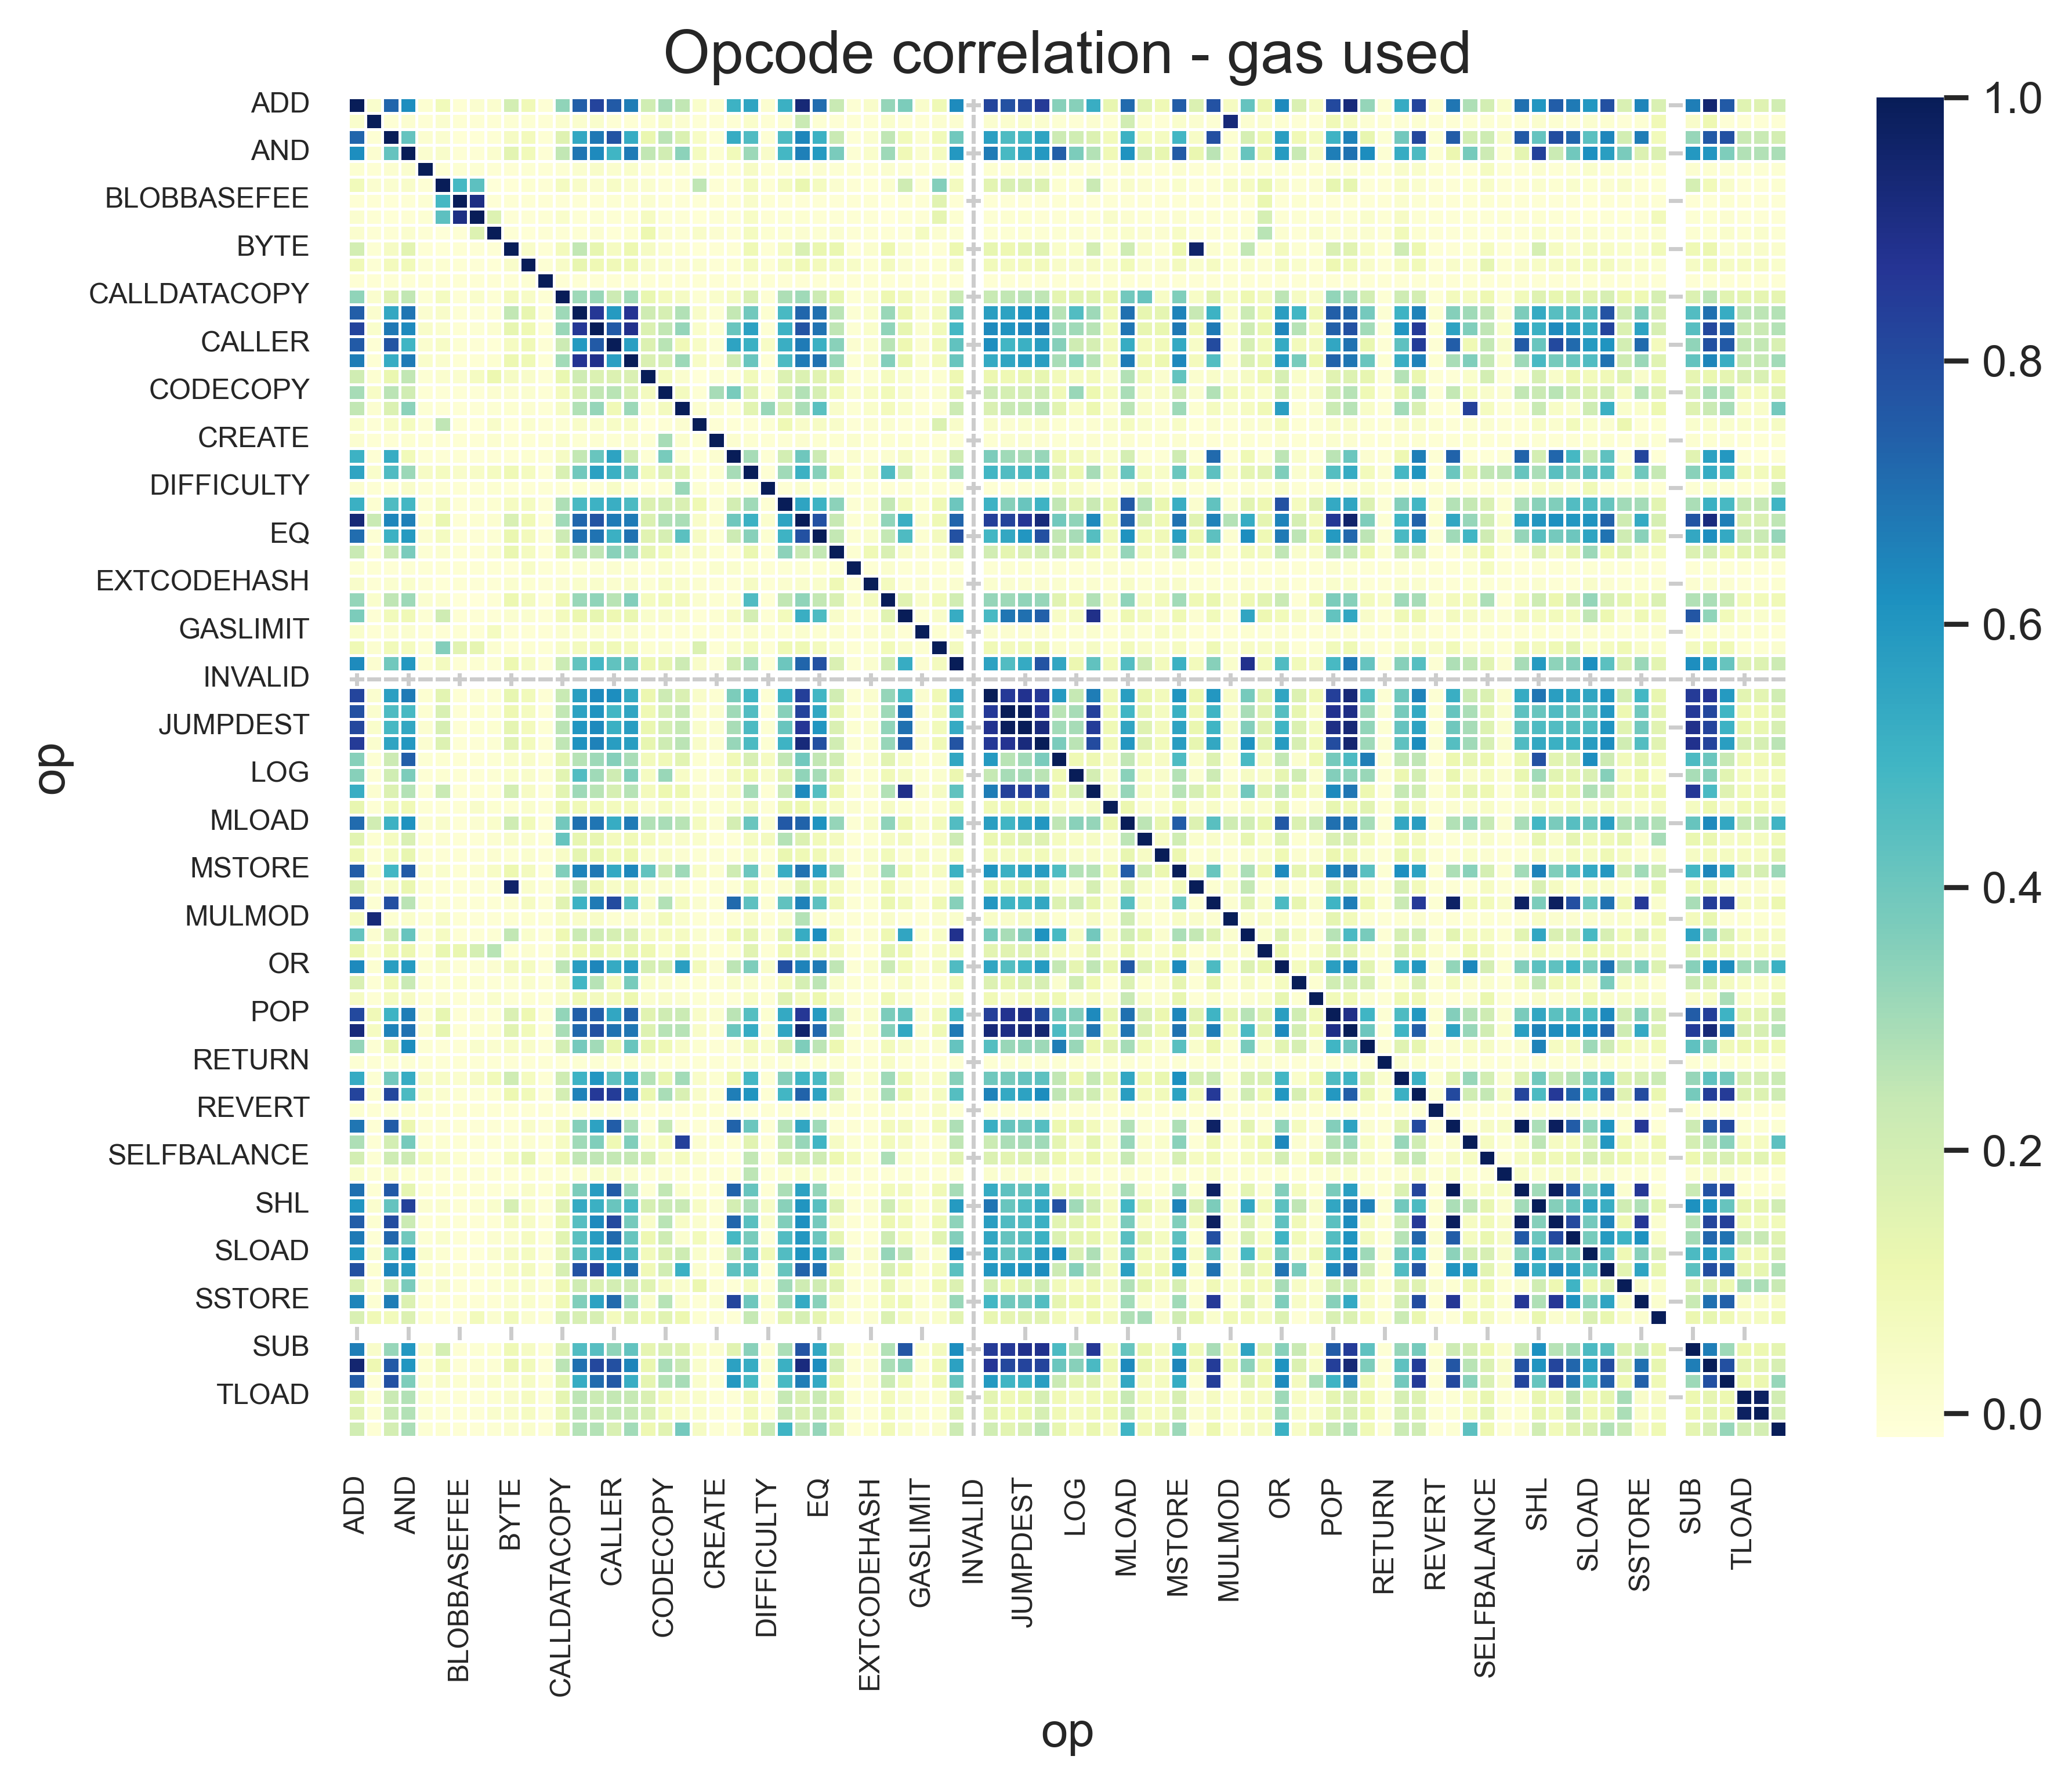

In [30]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()